In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import os
from itertools import product

In [2]:
def read_data(folder, prefix, postfix):
    b, eevpd = [], []
    for dir in os.listdir(folder):
        if (dir[:len(prefix)] == prefix) and (dir[len(prefix)+1:] == postfix):
            data = np.load(folder + dir)
            eps = data['stepsize']
            b.append(np.median(np.min(data['bias'], axis= -1), axis= -1))
            eevpd.append(np.median(data['eevpd'], axis = -1))
    if len(b) == 0:
        return False, None, None
    else:
        b = np.array(b)
        mask = np.argmin(b, axis= 0)
        basym, eevpd = b[mask, np.arange(len(mask))], np.array(eevpd)[mask, np.arange(len(mask))]
        sort = np.argsort(eevpd)
        return True, eevpd[sort], basym[sort]

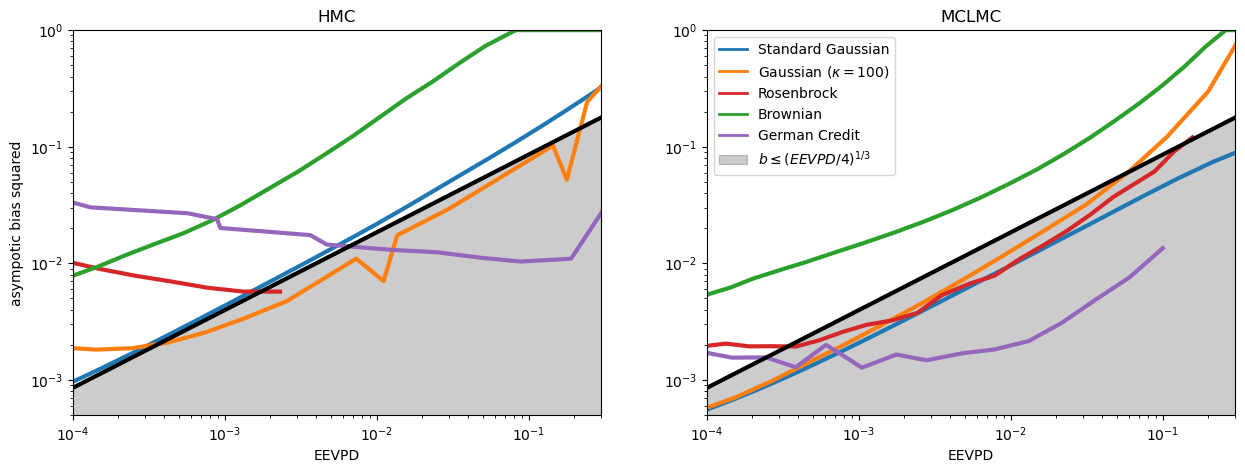

In [3]:
Method = namedtuple('Method', ['short_name', 'name', 'linestyle'])
Target = namedtuple('Target', ['short_name', 'name', 'color'])

targets = [Target('StandardNormal', 'Standard Gaussian', 'tab:blue'), 
           Target('IllConditionedGaussian', r'Gaussian ($\kappa = 100$)', 'tab:orange'),
           Target('Rosenbrock', 'Rosenbrock', 'tab:red'),
           Target('Brownian', 'Brownian', 'tab:green'),
           Target('GermanCredit', 'German Credit', 'tab:purple')
           ]

plt.figure(figsize = (15, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    method = [Method('hmc', 'HMC', '-'), Method('mclmc', 'MCLMC', '--')][i]
    plt.title(method.name)

    for target in targets:
        success, eevpd, basym = read_data('../data/bias/', method.short_name, '_' + target.short_name + '.npz')
        if success:
            plt.plot(eevpd, basym, lw= 3, color = target.color)
        
        
    plt.xscale('log')
    plt.yscale('log')
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
    E = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 100)
    analytical = lambda E: np.power(0.25 * E, 2./3.)
    plt.plot(E, analytical(E), lw=3, color= 'black')
    plt.fill_between(E, np.ones(len(E)) * ylim[0], analytical(E), alpha = 0.2, color= 'black', label= r'$b \leq (EEVPD / 4)^{1/3}$')


    # legend
    for target in targets:
        plt.plot([], [], '-', lw= 2, color= target.color, label= target.name)
    
# for method in methods:
#     plt.plot([], [], method.linestyle, lw=2, color= 'grey', label= method.name)
    if i == 0:
        plt.ylabel('asympotic bias squared')
    else:
        plt.legend()

    plt.ylim(5e-4, 1)
    plt.xlim(1e-4, 0.3)

    plt.xlabel('EEVPD')
    
plt.show()

In [4]:
from scipy.stats import linregress

def get_range(desired_range, method, target):
    data = np.load('../data/bias/' + method + '_' + target + '.npz')
    eps, eevpd = data['stepsize'], np.average(data['eevpd'], axis = -1)
    res = linregress(np.log(eevpd), np.log(eps))
    return np.exp(res.slope * np.log(desired_range) + res.intercept)

def plot_range(method, target):
    data = np.load('../data/bias/' + method + '_' + target + '.npz')
    eps, eevpd = data['stepsize'], np.average(data['eevpd'], axis = -1)
    res = linregress(np.log(eevpd), np.log(eps))
    eps_linfit= np.exp(res.slope * np.log(eevpd))
    
    plt.plot(eps, eevpd, 'o')
    plt.plot(eps_linfit, eevpd)
    plt.xscale('log')
    plt.yscale('log')


def plott(method, target):
    data = np.load('../data/bias/' + method + '_' + target + '.npz')
    eps, eevpd = data['stepsize'], np.average(data['eevpd'], axis = -1)
    n = np.arange(1, len(data['bias'][0, 0, :])+1) * 100
    for i in range(4):
        plt.plot(n, data['bias'][0, i, :])
    plt.xscale('log')
    plt.yscale('log')

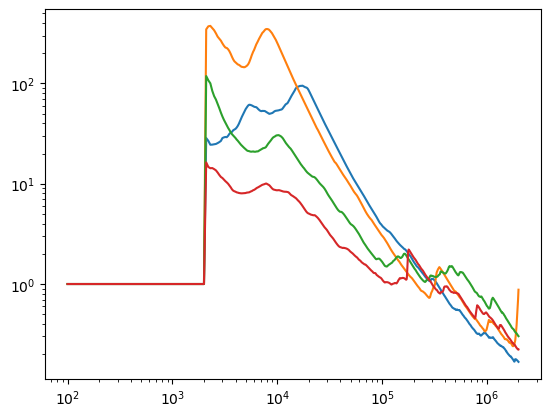

In [5]:
plott('hmc5', 'GermanCredit')

In [ ]:

desired_range = [7e-5, 0.5]

for method, target in product(['hmc2', 'hmc3', 'mclmc1'], targets):
    try:
        print(method + ', ' + target.name, get_range(desired_range, method, target.short_name))
    except:
        print(method + ', ' + target.name)